In [1]:
# import required libraries

import os
import sys
import configparser

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import RandomAffine

In [2]:
# set the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


In [3]:
# set the hyperparameters

config = configparser.ConfigParser()

config['CAE'] = {'rand_seed': 765, 'ks': 3, 'nf0': 15, 'nf1': 45, 'nf2': 128, 'nf3': 196, 'nf4': 128, 'nf5': 128, 'nf6': 128,
                 'nfc': 14}

config['IM'] = {'lambda_affine': 0.03, 'lambda_marginal_entropy': 0.1, 'lambda_conditional_entropy': 0.03,
                'learning_rate': 0.003}

config.write(sys.stdout)

[CAE]
rand_seed = 765
ks = 3
nf0 = 15
nf1 = 45
nf2 = 128
nf3 = 196
nf4 = 128
nf5 = 128
nf6 = 128
nfc = 14

[IM]
lambda_affine = 0.03
lambda_marginal_entropy = 0.1
lambda_conditional_entropy = 0.03
learning_rate = 0.003



In [4]:
rand_seed = int(config['CAE']['rand_seed'])
ks        = int(config['CAE']['ks'])
nf0       = int(config['CAE']['nf0'])
nf1       = int(config['CAE']['nf1'])
nf2       = int(config['CAE']['nf2'])
nf3       = int(config['CAE']['nf3'])
nf4       = int(config['CAE']['nf4'])
nf5       = int(config['CAE']['nf5'])
nf6       = int(config['CAE']['nf6'])
nfc       = int(config['CAE']['nfc'])

In [5]:
lambda_affine              = float(config['IM']['lambda_affine'])
lambda_marginal_entropy    = float(config['IM']['lambda_marginal_entropy'])
lambda_conditional_entropy = float(config['IM']['lambda_conditional_entropy'])
learning_rate              = float(config['IM']['learning_rate'])

In [6]:
# set random seed

print('random seed:', rand_seed)

torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
np.random.seed(rand_seed)

random seed: 765


In [7]:
# load the dataset

data_src = np.load('/project/dsc-is/mahfujul-r/M/slice128_Block2_20K.npy') # location of the dataset

In [8]:
# custom functions to extract batches of samples

def get_batch_index_tr(tr, batch_size=None, shuffle=True):
    if (shuffle):
        np.random.shuffle(tr)
    if (batch_size is not None):
        n_batch = len(tr) // batch_size
    batch_list = np.array_split(tr, n_batch)
    return batch_list

def get_batch_index_ae(ae, batch_size=None, shuffle=True):
    tr = np.arange(ae)
    batch_list = get_batch_index_tr(tr, batch_size=batch_size, shuffle=shuffle)
    return batch_list

In [9]:
ix, iy = 64, 64 # 128x128 patches are getting rescaled

#affine transformation
add_random_affine = RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=(161, 138, 172)) 

def generate_batch(iii, src, device, random_affine=False):
    if (random_affine):
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0])
            img_tmp0 = add_random_affine(img_tmp0).resize((ix, iy)) # HE
            img_tmp4 = Image.fromarray(src[ii, 4])
            img_tmp4 = add_random_affine(img_tmp4).resize((ix, iy)) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5])
            img_tmp5 = add_random_affine(img_tmp5).resize((ix, iy)) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6])
            img_tmp6 = add_random_affine(img_tmp6).resize((ix, iy)) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7])
            img_tmp7 = add_random_affine(img_tmp7).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    else:
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0]).resize((ix, iy)) # HE
            img_tmp4 = Image.fromarray(src[ii, 4]).resize((ix, iy)) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5]).resize((ix, iy)) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6]).resize((ix, iy)) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7]).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    return (xxx.to(device))

In [10]:
iii_trn = np.arange(0, 15000) # first 15000 samples to be used for training

In [11]:
iii_batch = get_batch_index_tr(iii_trn, batch_size=15, shuffle=True)
iii = iii_batch[0] # select first batch

In [12]:
# generate original and trnasformed samples in batches

xxx_tmp = generate_batch(iii, data_src, device)
xxa_tmp = generate_batch(iii, data_src, device, random_affine=True)

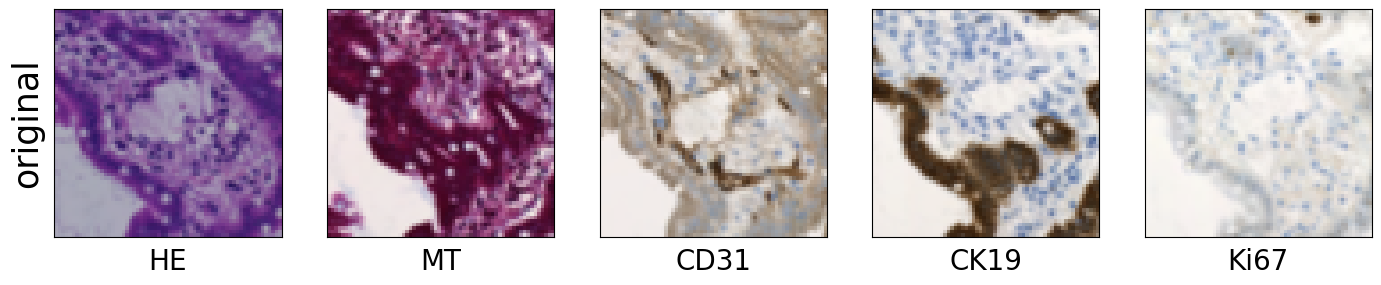

In [13]:
# original sample with 5 stainings

fig1, ax1 = plt.subplots(1, 5, figsize=(17, 5))
tmp = []
tmp.append(xxx_tmp[0, 0:3].detach().cpu().permute(1, 2, 0).numpy())
tmp.append(xxx_tmp[0, 3:6].detach().cpu().permute(1, 2, 0).numpy())
tmp.append(xxx_tmp[0, 6:9].detach().cpu().permute(1, 2, 0).numpy())
tmp.append(xxx_tmp[0, 9:12].detach().cpu().permute(1, 2, 0).numpy())
tmp.append(xxx_tmp[0, 12:15].detach().cpu().permute(1, 2, 0).numpy())
ax1[0].imshow(tmp[0])
ax1[1].imshow(tmp[4])
ax1[2].imshow(tmp[1])
ax1[3].imshow(tmp[2])
ax1[4].imshow(tmp[3])
ax1[0].set_ylabel('original', fontsize=25)
ax1[0].set_xlabel('HE', fontsize=20)
ax1[1].set_xlabel('MT', fontsize=20)
ax1[2].set_xlabel('CD31', fontsize=20)
ax1[3].set_xlabel('CK19', fontsize=20)
ax1[4].set_xlabel('Ki67', fontsize=20)
ax1[0].set_xticks([])
ax1[1].set_xticks([])
ax1[2].set_xticks([])
ax1[3].set_xticks([])
ax1[4].set_xticks([])
ax1[0].set_yticks([])
ax1[1].set_yticks([])
ax1[2].set_yticks([])
ax1[3].set_yticks([])
ax1[4].set_yticks([]);

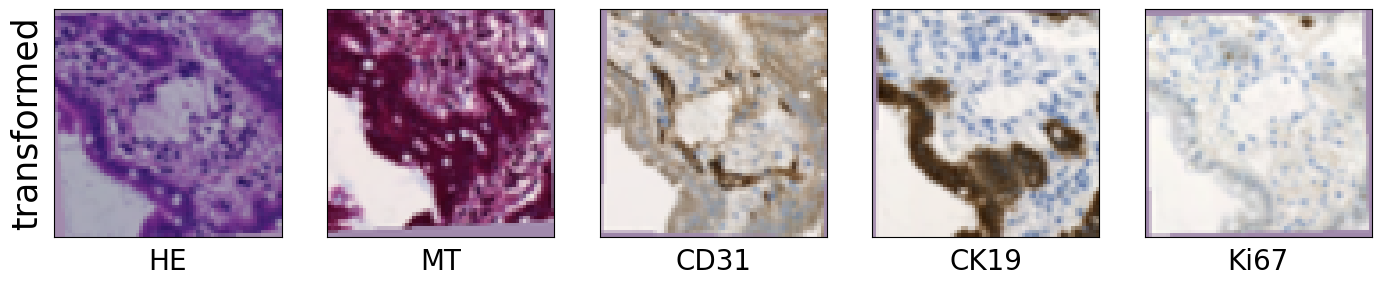

In [14]:
# transformed sample with 5 stainings

fig2, ax2 = plt.subplots(1, 5, figsize=(17, 5))
tmp_ = []
tmp_.append(xxa_tmp[0, 0:3].detach().cpu().permute(1, 2, 0).numpy())
tmp_.append(xxa_tmp[0, 3:6].detach().cpu().permute(1, 2, 0).numpy())
tmp_.append(xxa_tmp[0, 6:9].detach().cpu().permute(1, 2, 0).numpy())
tmp_.append(xxa_tmp[0, 9:12].detach().cpu().permute(1, 2, 0).numpy())
tmp_.append(xxa_tmp[0, 12:15].detach().cpu().permute(1, 2, 0).numpy())
ax2[0].imshow(tmp_[0])
ax2[1].imshow(tmp_[4])
ax2[2].imshow(tmp_[1])
ax2[3].imshow(tmp_[2])
ax2[4].imshow(tmp_[3])
ax2[0].set_ylabel('transformed', fontsize=25)
ax2[0].set_xlabel('HE', fontsize=20)
ax2[1].set_xlabel('MT', fontsize=20)
ax2[2].set_xlabel('CD31', fontsize=20)
ax2[3].set_xlabel('CK19', fontsize=20)
ax2[4].set_xlabel('Ki67', fontsize=20)
ax2[0].set_xticks([])
ax2[1].set_xticks([])
ax2[2].set_xticks([])
ax2[3].set_xticks([])
ax2[4].set_xticks([])
ax2[0].set_yticks([])
ax2[1].set_yticks([])
ax2[2].set_yticks([])
ax2[3].set_yticks([])
ax2[4].set_yticks([]);